In [1]:
import py_agp
import numpy as np
import math
import matplotlib.pyplot as plt
from decimal import *
#from mpmath import *

In [2]:
def MultKron(ops):
    '''Pass in a list of operators, return the Kronecker product of all of them'''
    opout=np.kron(ops[0],ops[1])
    for n in range(2,len(ops)):
        opout = np.kron(opout,ops[n])
    return opout

In [3]:
def HamconIsingprec(Ns,hx,hz,prec):
    '''Construct NN Ising model (ZZ exchange) for Ns spins in a magnetic field with components
    hx, hz starting keeping prec digits.  '''
    getcontext().prec=prec
    
    #Define spin operators
    Sx = [[Decimal(0),Decimal(1)],[Decimal(1),Decimal(0)]]
    Sz = [[Decimal(1),Decimal(0)],[Decimal(0),Decimal(-1)]]
    idprec = [[Decimal(1),Decimal(0)],[Decimal(0),Decimal(1)]]
    
    #Set a table of operators to build interactions out of applications of MultKron
    optab = [idprec for i in range(Ns)]
    Ham = [[Decimal(0) for i in range(2**Ns)] for j in range(2**Ns)]
    O0 = [[Decimal(0) for i in range(2**Ns)] for j in range(2**Ns)]
   
    for p in range(Ns-1):
        optab[p] = Sx
        #Take O0 to be a single spin flip (Sx) at center of chain
        if p+1==math.ceil(Ns/2):
            O0+=MultKron(optab)
            
        #Add in hx piece
        Ham += hx*MultKron(optab)
        optab[p] = Sz
        #NN exchange
        Ham += hz*MultKron(optab)
        optab[p+1] = Sz
        #hz piece
        Ham += MultKron(optab)
        
        #Reset optab for the next iteration
        optab[p] = idprec
        optab[p+1] = idprec
        
    
    #We left out fields on site N-1, so loop those in:    
    optab[Ns-1] = Sx
    Ham += hx*MultKron(optab)
    optab[Ns-1] = Sz
    Ham += hz*MultKron(optab)
    
    return Ham, O0

In [16]:
def LancconIsingprec(Ns,Nl,hx,hz,prec):
    '''Compute the first Nl Lanczos coefficients for the Ising model. Code halts whenever
    a Lanczos coefficient is found to be zero.'''
    
    getcontext().prec=prec
    
    #Compute Ham, O0:
    Ham, O = HamconIsingprec(Ns,hx,hz,prec)
    
    
    
    data = []
    for val in np.ndenumerate(Ham):
        #print(val)
        if abs(val[1])>1e-16:
            data.append((val[0][0],val[0][1],str(val[1])))
    H=py_agp.SparseBiDirectional(data,prec)
    
    
    
    O0 = py_agp.DenseMatrix.new_empty(O.shape[0],prec)
    for ((r,c), val) in np.ndenumerate(O):
        O0.set_val(r,c,str(val))
    
    
    #Empty list will later store Lanczos coefficients
    Lanczos = []
    #Store Hilbert space dimension for later
    D = py_agp.FloatEntry(str(2**(Ns)), prec).sqrt()
    print(D)
    Dinv = py_agp.FloatEntry(str("1.0"), prec) / D
    print(Dinv)
    #D = Decimal(2**Ns)
    #Normalize the initial operator
    #O0/=(O0.norm2()/D)
    O0/=O0.norm2()
    O0*=D
    #O0 /= (O0.norm2()/Decimal.sqrt(D))
    #O0 /= Decimal.sqrt(np.trace(np.matmul(O0.transpose(),O0))/D)
    
    #First Lanczos iteration: compute commutator of O0 with H, normalize the resulting operator,
    #and store the normalization constant as the first Lanczos coefficient. Then define operators
    #Onm1, Onm2 which will be updatd iteratively in the following loop.
    
    A1 = H@O0 - O0@H
    b1=A1.norm2()
    b1 = A1.norm2()*Dinv
    Lanczos.append(b1)
    
    Onm2=O0
    Onm1=A1/b1
    
    #Now repeat this to compute the first Nl Lanczos coefficients. 
    for c in range(Nl-1):
        An = H@Onm1 - Onm1@H - Onm2*Lanczos[-1]
        bn = An.norm2()*Dinv
        
        
        #bn = An.norm2()/Decimal.sqrt(D)
        #bn = Decimal.sqrt(np.trace(np.matmul(An.transpose(),An))/D)
        if bn==0:
            break
        
        Lanczos.append(bn)
        Onm2 = Onm1
        Onm1 = An/bn
    
    return Lanczos

In [17]:
getcontext().prec=100
hx = (Decimal.sqrt(Decimal(5))+5)/8
hz = (Decimal.sqrt(Decimal(5))+1)/4

H,O = HamconIsingprec(3,hx,hz,100)

In [18]:
data = []
for val in np.ndenumerate(H):
    #print(val)
    if abs(val[1])>1e-12:
        data.append((val[0][0],val[0][1],str(val[1])))


H=py_agp.SparseBiDirectional(data,100)
O0 = py_agp.DenseMatrix.new_empty(O.shape[0],100)

[2.828427124746190097603377448419396157139343750753896146353359475981464956924214077700775068655283145470027692461824594049849672111701474425288242994199871662826445331855011185511599901002305564121142940219119943211940549069193724029457034837281778397219104658460968617428642901679525207255990502815979374506804]
[3.535533905932737622004221810524245196424179688442370182941699344976831196155267597125968835819103931837534615577280742562312090139626843031610303742749839578533056664818763981889499876252881955151428675273899929014925686336492155036821293546602222996523880823076210771785803627099406509069988128519974218133477e-1]


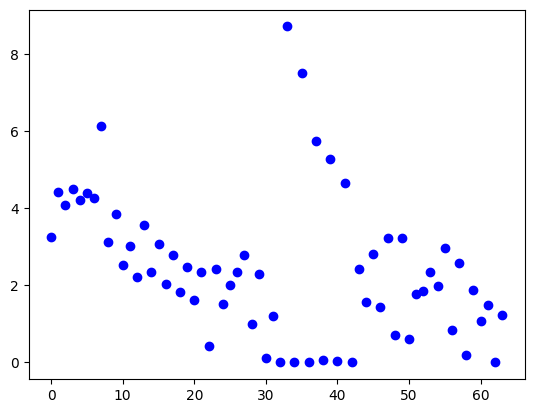

In [19]:
getcontext().prec=1024
hx = (Decimal.sqrt(Decimal(5))+5)/8
hz = (Decimal.sqrt(Decimal(5))+1)/4

lanc=LancconIsingprec(3,4**3,hx,hz,1024)
plt.plot([lanc[i].to_float() for i in range(len(lanc))],'bo')
plt.show()

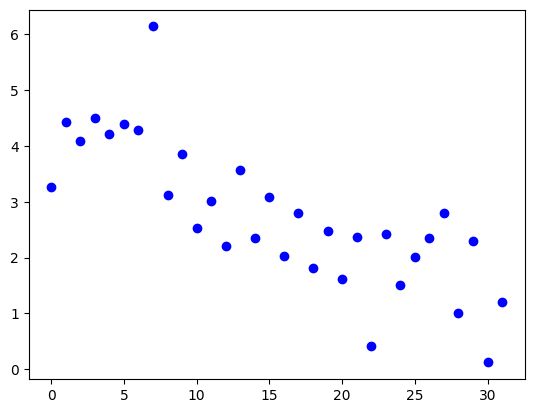

In [20]:
plt.plot([lanc[i].to_float() for i in range(32)],'bo')

In [21]:
getcontext().prec=100
hx = (Decimal.sqrt(Decimal(5))+5)/8
hz = (Decimal.sqrt(Decimal(5))+1)/4

LancconIsingprec(5,4**5,hx,hz,100)

[5.6568542494923801952067548968367]
[1.7677669529663688110021109052634e-1]


[[3.2585324900558985907489696660862],
 [4.4334802903884539423478044118266],
 [4.1438751710175302657931786934982],
 [4.9857620613835928410678608062915],
 [5.2467170145283784099369062057114],
 [5.8381273766741050429951855501435],
 [5.9822195114412409585488966032517],
 [6.9377673776843543396452443728123],
 [7.3409864146277099948189605326842],
 [7.9343751983927334114886953176197],
 [7.5523930024465359039575067522457],
 [7.8312162194470310420112603167635],
 [7.5124547780187280748814714666169],
 [7.4047052720747556909042555653581],
 [7.4679833922595412681539331112567],
 [7.8814502758564812623802832436397],
 [7.9030997758356287863878496302439],
 [8.1937068731192588331013319808973],
 [8.0836166819663574766953250387783],
 [7.2374074373352744668001136262998],
 [5.5804279810827380264433785379182],
 [6.3133671410036431710967922877919],
 [6.5734056335604578451315163927834],
 [5.9944195143856597611838920360984],
 [5.4026562829569541830869926359457],
 [6.0977220362571431518431434201939],
 [6.08750622

In [22]:
getcontext().prec=200
hx = (Decimal.sqrt(Decimal(5))+5)/8
hz = (Decimal.sqrt(Decimal(5))+1)/4

LancconIsingprec(5,4**5,hx,hz,200)

[5.6568542494923801952067548968387923142786875015077922927067185]
[1.7677669529663688110021109052621225982120898442211850914708495e-1]


[[3.2585324900558985907489696660839366558818058397916515759046899],
 [4.4334802903884539423478044118220178673646846075311537346853820],
 [4.1438751710175302657931786935075349036361760814228661194859356],
 [4.9857620613835928410678608062894517090401425944977184381929750],
 [5.2467170145283784099369062057061583481519854275684955719241673],
 [5.8381273766741050429951855501392223298928221367948319328945838],
 [5.9822195114412409585488966032502711122610053037770841473824145],
 [6.9377673776843543396452443728101654425920514160711721851279403],
 [7.3409864146277099948189605326854374485874206374123176607737705],
 [7.9343751983927334114886953176231912993070546329752845825917121],
 [7.5523930024465359039575067522503441408092197888111046532747243],
 [7.8312162194470310420112603167892370288711276416288289210662100],
 [7.5124547780187280748814714666444772404468966882300557678765003],
 [7.4047052720747556909042555653798958685368644938178052447028794],
 [7.46798339225954126815393311128356385481625270

[5.65685424949238019520675489683879231427868750150779229270671895196292991384842815540155013731056629094005538492364918809969934422340294885057648598839974332565289066371002237102319980200461112824228588043823988642388109813838744805891406967456355679443820931692193723485728580335905041451198100563195874901358618532723531856248246103340958021898300115103984691934230088135012742804541749841363399538864154759988279601926012217611116126581699129227397174767448632231385244638667485205206247427594894894115403705944499799086168733368171427442405872988830857434194966226282787106148809059417880634352064830338996906289033]
[1.767766952966368811002110905262122598212089844221185091470849672488415598077633798562984417909551965918767307788640371281156045069813421515805151871374919789266528332409381990944749938126440977575714337636949964507462843168246077518410646773301111498261940411538105385892901813549703254534994064259987109066745682914761037050775769072940493818432187859699952162294469025421914

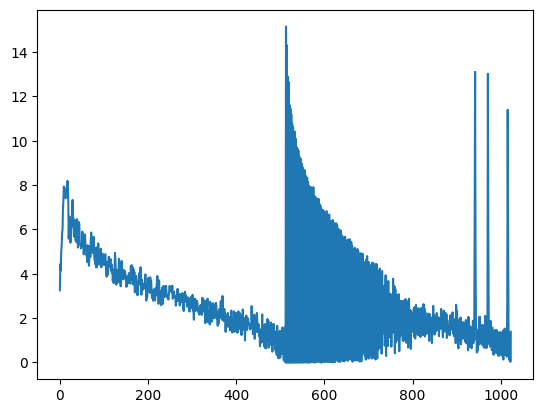

In [23]:
getcontext().prec=2048
hx = (Decimal.sqrt(Decimal(5))+5)/8
hz = (Decimal.sqrt(Decimal(5))+1)/4

lanc=LancconIsingprec(5,4**5,hx,hz,2048)
plt.plot([lanc[i].to_float() for i in range(len(lanc))])

In [24]:
lanc[1]

[4.43348029038845394234780441182201786736468460753115373468537656221752006547212479171725473177091231198549015459272317893762885752999092598057121960102502420998342228850425474408296853945545419434948920702982490525223549486289126696122294224891554516871685519159927165119259126324307759358966838599075003835599326310300795425810211951845326892060851308316379733214142399730744892645339277014433327380909996492260643149425525276779018012748302500525886850880727429166237064080510413932298365659145482122532296570442795898948745294811986088108573092267326708202810239885520121015607789353718099276365292190941710839434280]

In [25]:
getcontext().prec=16
hx = (Decimal.sqrt(Decimal(5))+5)/8
hz = (Decimal.sqrt(Decimal(5))+1)/4

H,O = HamconIsingprec(3,hx,hz,512)

In [26]:
H

array([[Decimal('4.4270509831248425'), Decimal('0.9045084971874738'),
        Decimal('0.9045084971874738'), Decimal('0E-16'),
        Decimal('0.9045084971874738'), Decimal('0E-16'),
        Decimal('0E-16'), Decimal('0E-16')],
       [Decimal('0.9045084971874738'), Decimal('0.8090169943749475'),
        Decimal('0E-16'), Decimal('0.9045084971874738'),
        Decimal('0E-16'), Decimal('0.9045084971874738'),
        Decimal('0E-16'), Decimal('0E-16')],
       [Decimal('0.9045084971874738'), Decimal('0E-16'),
        Decimal('-1.1909830056250525'), Decimal('0.9045084971874738'),
        Decimal('0E-16'), Decimal('0E-16'),
        Decimal('0.9045084971874738'), Decimal('0E-16')],
       [Decimal('0E-16'), Decimal('0.9045084971874738'),
        Decimal('0.9045084971874738'), Decimal('-0.8090169943749475'),
        Decimal('0E-16'), Decimal('0E-16'), Decimal('0E-16'),
        Decimal('0.9045084971874738')],
       [Decimal('0.9045084971874738'), Decimal('0E-16'),
        Decimal('0E-16'),

In [27]:
a = py_agp.FloatEntry(str(1.0), 1000)
print(a)

[1.00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000]
